# CHAMP Transects Notebook

<img style="float:right;" src="https://id.dewberry.com/clients/Templates/DewberryLogo_RGB.png" width=150px>

### Description
Read data from Microsoft Access

---

#### - Requirements
  1. whafis_champ library
  2. Microsoft Access files
  
#### - Usage:
  1. Import Libraries & Assign Paths
  2. Read in data from files:
  
 ---

### Import Libraries

In [1]:
import pyodbc
import pandas as pd
import numpy as np
from importlib import reload
import whafis_champ ; reload(whafis_champ)
from whafis_champ import *
from matplotlib import pyplot as plt
import os
%matplotlib inline

### Assign Paths

In [2]:
root_dir = r'P:\Temp\tmiesse\for_Jeff_transects'
mbd      = 'Charlotte_CHAMP.mdb'
path     = os.path.join(root_dir,mbd)

### Open the Microsoft Access Data

#### EROSION

In [3]:
select = 'EROSION'
dfE = micro_access_open(path,select)
dfE.rename(columns={0:'Transect', 1:'Station', 2:'Elevation'}, inplace=True)
transects = list(dfE['Transect'].unique() )

#### TRANSECT

In [4]:
select = 'TRANSECT'
dfT2 = micro_access_open(path,select)
dfT2.rename(columns={0:'Transect', 1:'Station', 2:'Elevation'}, inplace=True)
transects_orig = list(dfT2['Transect'].unique())

#### WHAFIS Part 2

In [5]:
select = '[WHAFIS PART 2]'
dfW2 = micro_access_open(path,select)
dfW2.rename(columns={0:'Transect', 1:'WHAFIS_CARD', 2:'Stations',3:'Wave_height',
                     4:'Wave_period',5:'Wave_crest_elevation'}, inplace=True)
transects_wave = list(dfW2['Transect'].unique())

#### STILLWATER

In [6]:
select = 'STILLWATER'
dfS2 = micro_access_open(path,select)
dfS2.rename(columns={0:'Transect', 1:'Station', 2:'10_year_swell',3:'100_year_swell'}, inplace=True)
transects_still = list(dfS2['Transect'].unique())

#### WHAFIS PART 6

In [7]:
select = '[WHAFIS PART 6]'
dfZ2 = micro_access_open(path,select)
dfZ2.rename(columns={0:'Transect', 1:'Station begin', 2:'elevation begin',3:'station end',4:'elevation end',5:'zone',
                    6:'zone elevation',7:'FHF'}, inplace=True)
transects_zone = list(dfZ2['Transect'].unique())

### Plot Data

In [8]:
title = 'Charlotte County - Wave Envelope Profile'

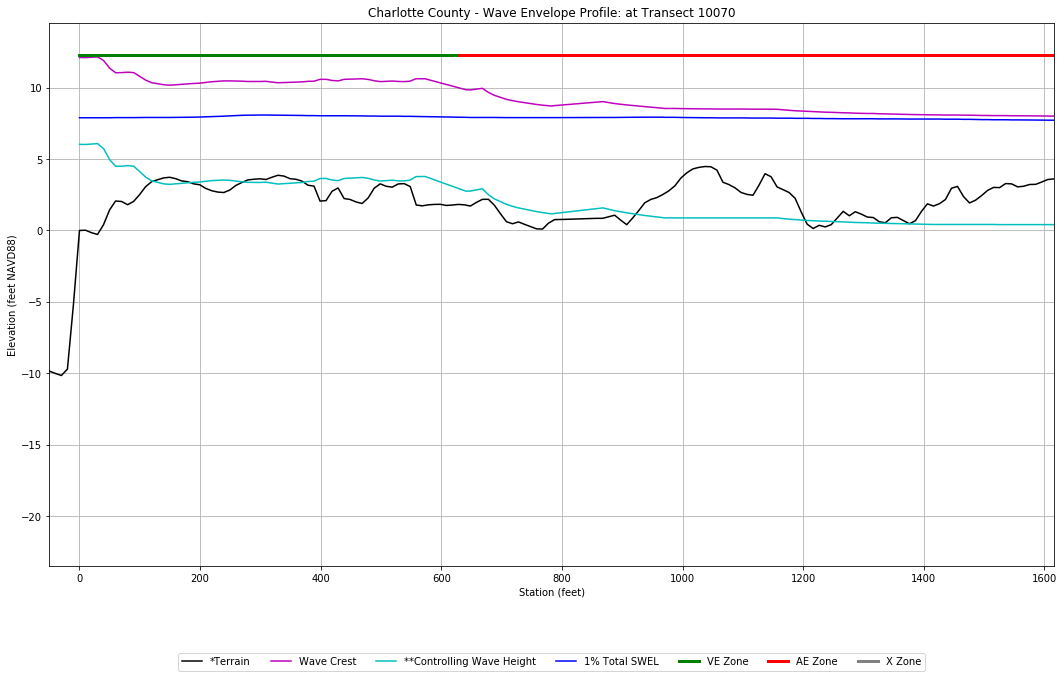

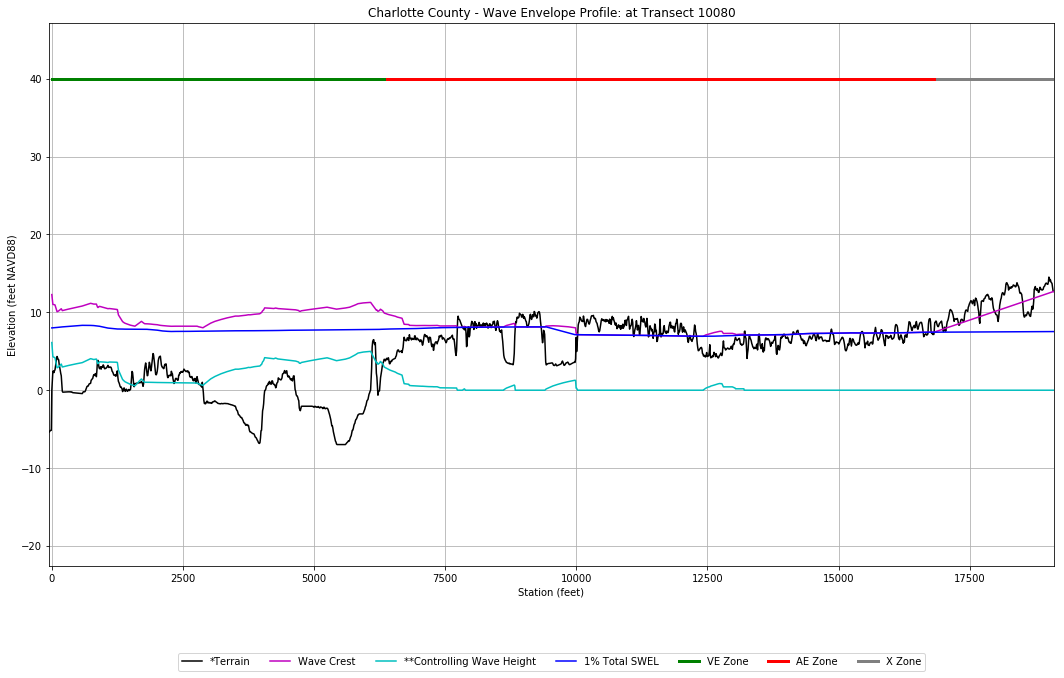

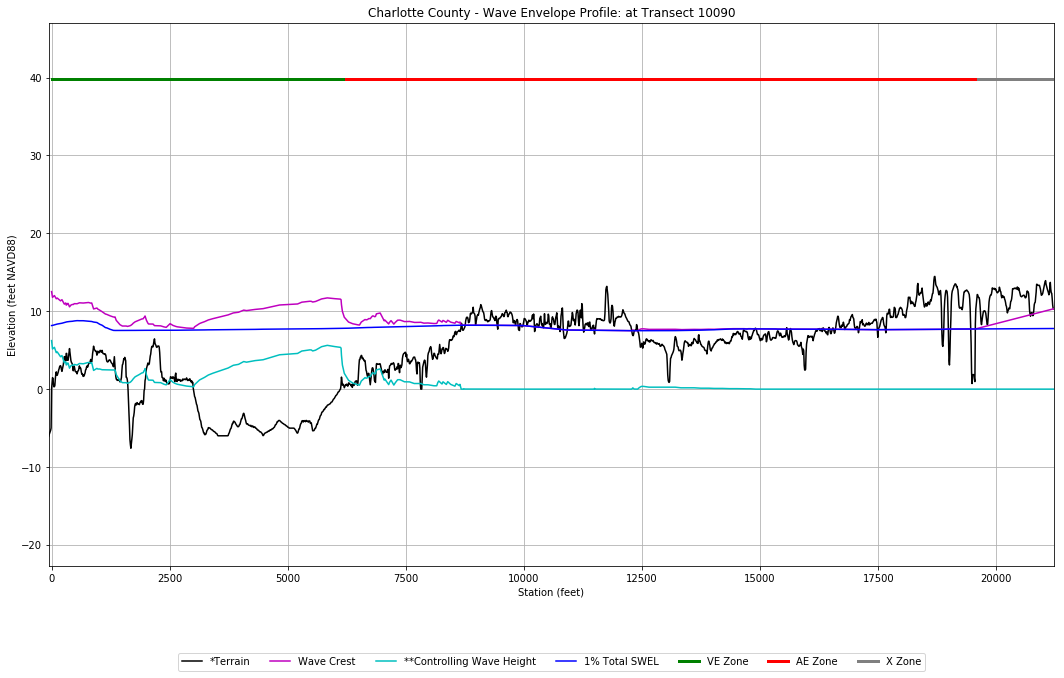

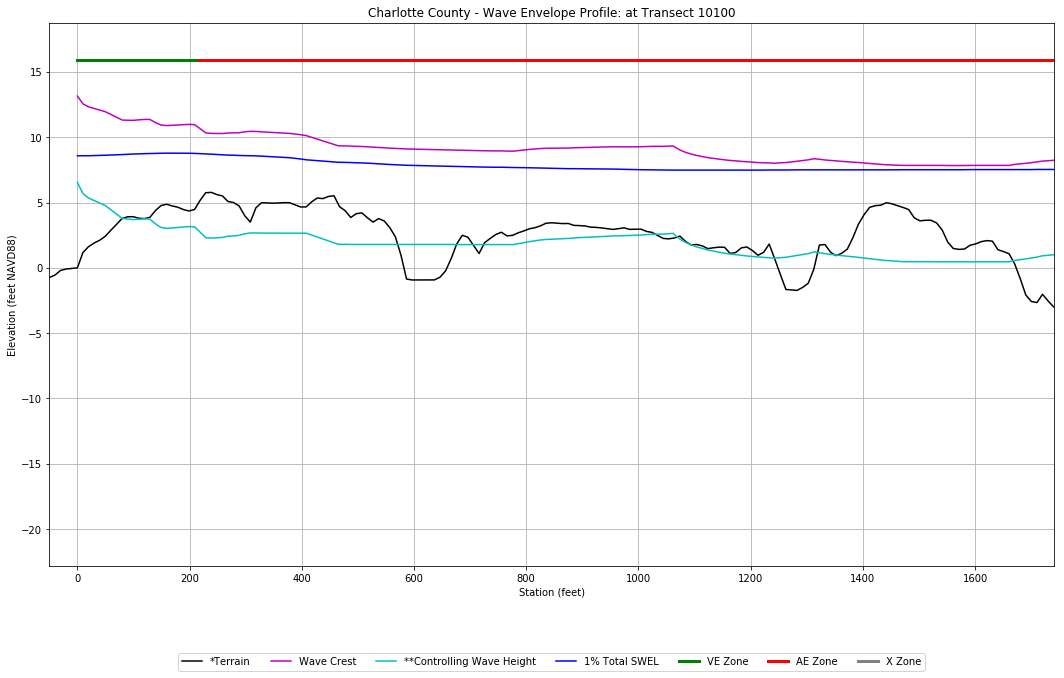

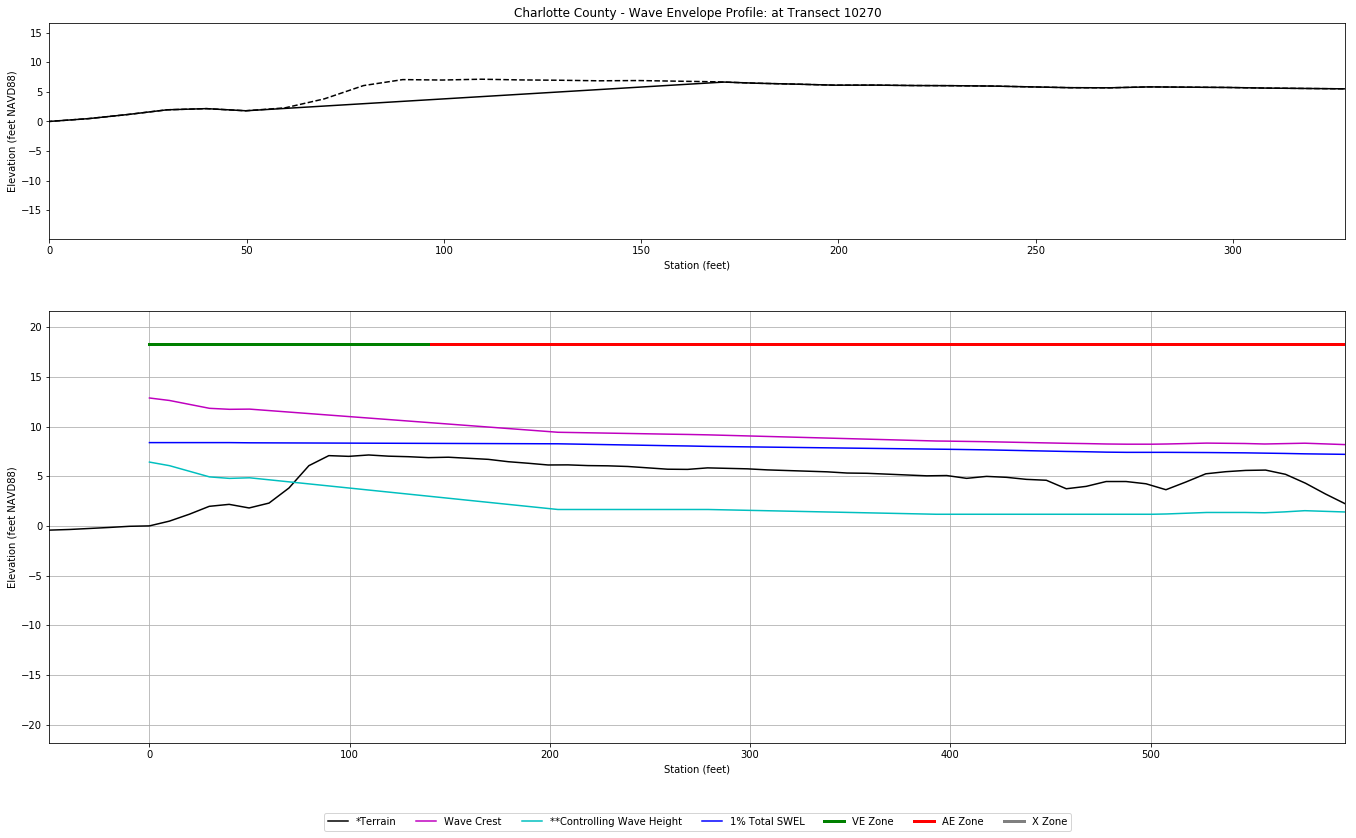

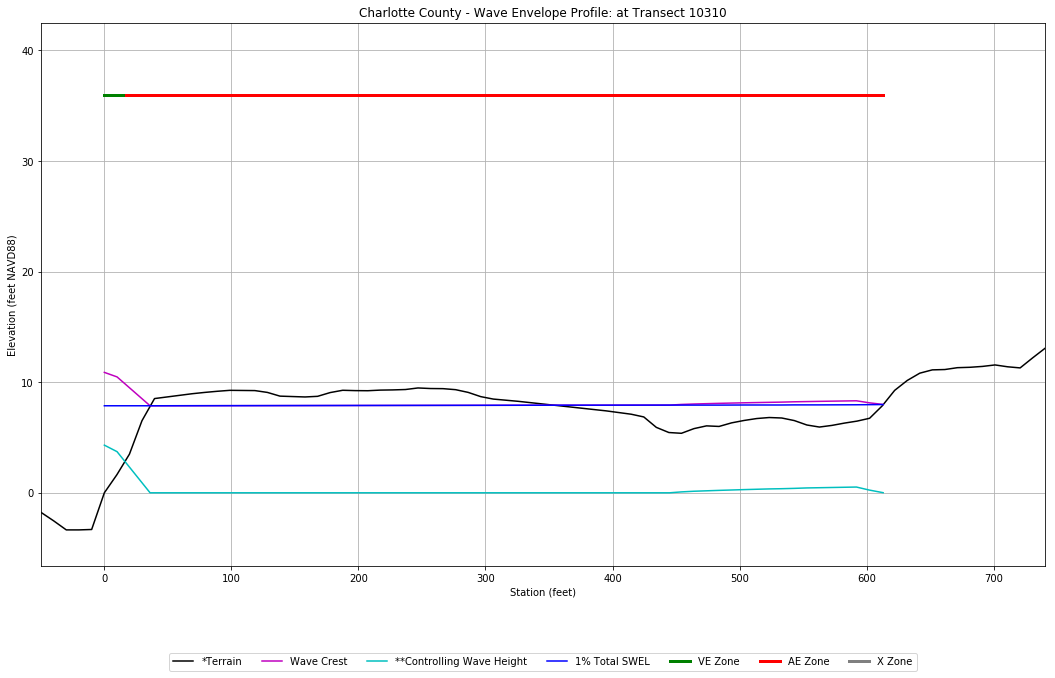

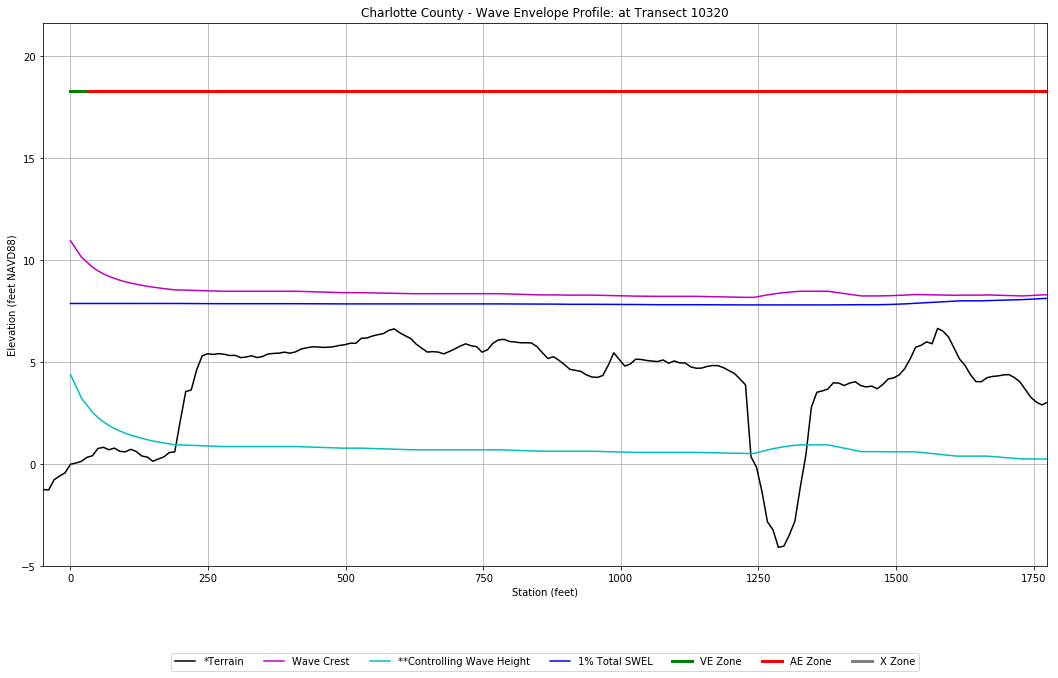

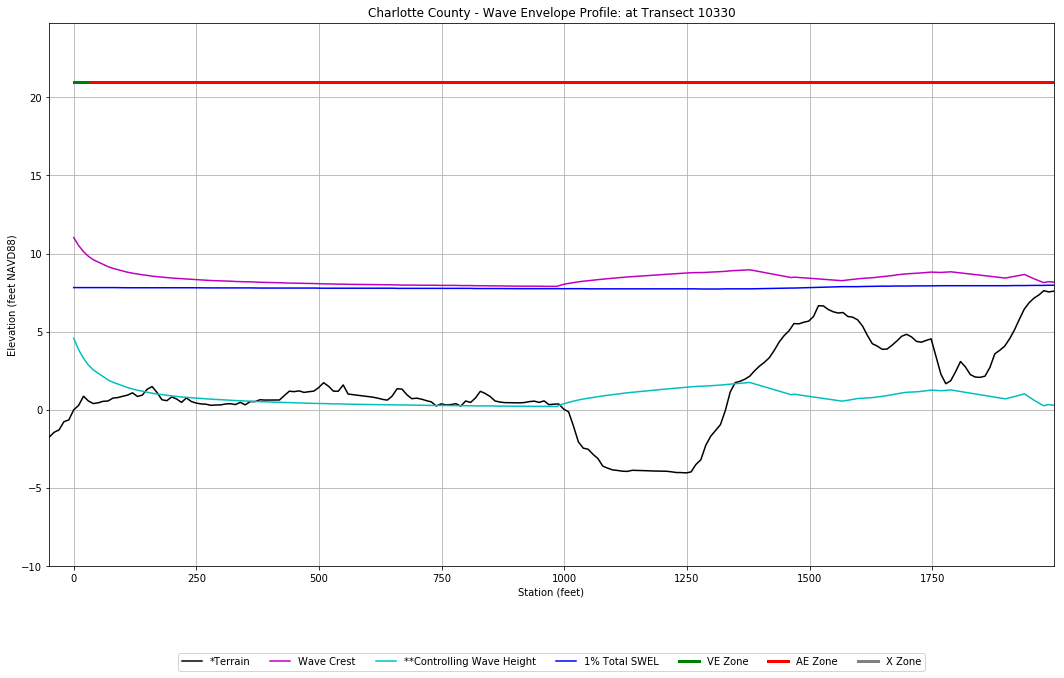

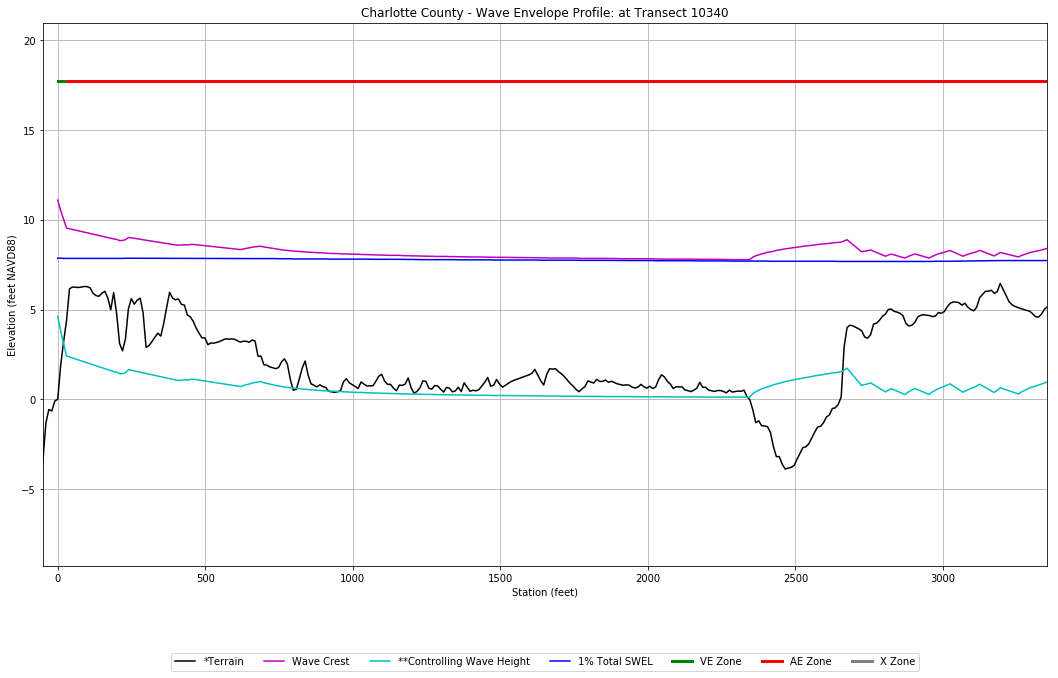

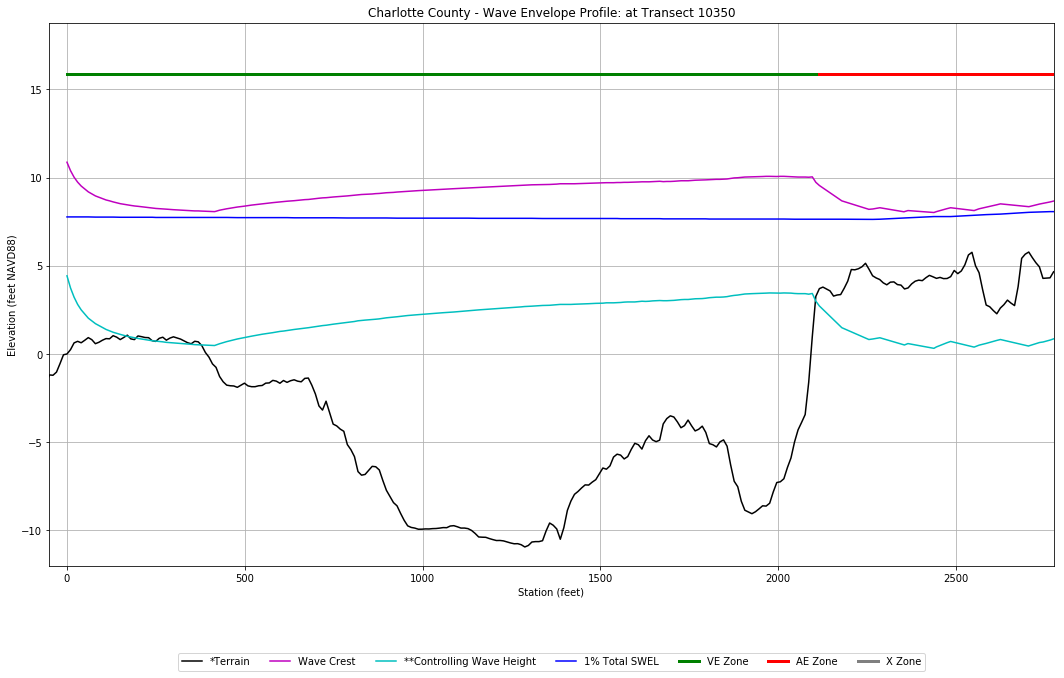

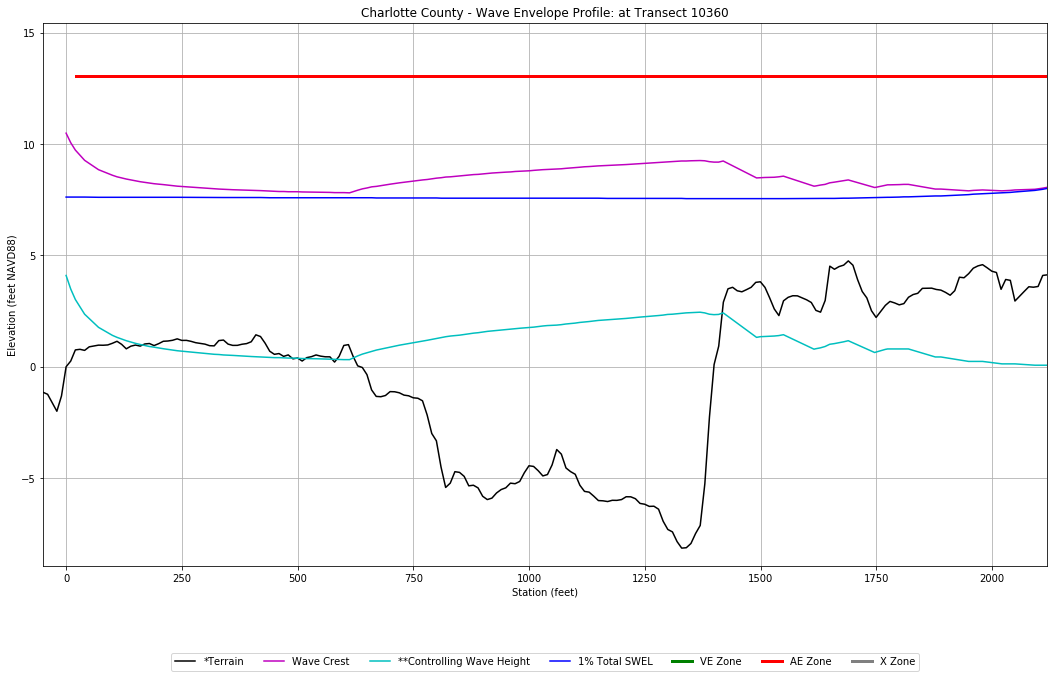

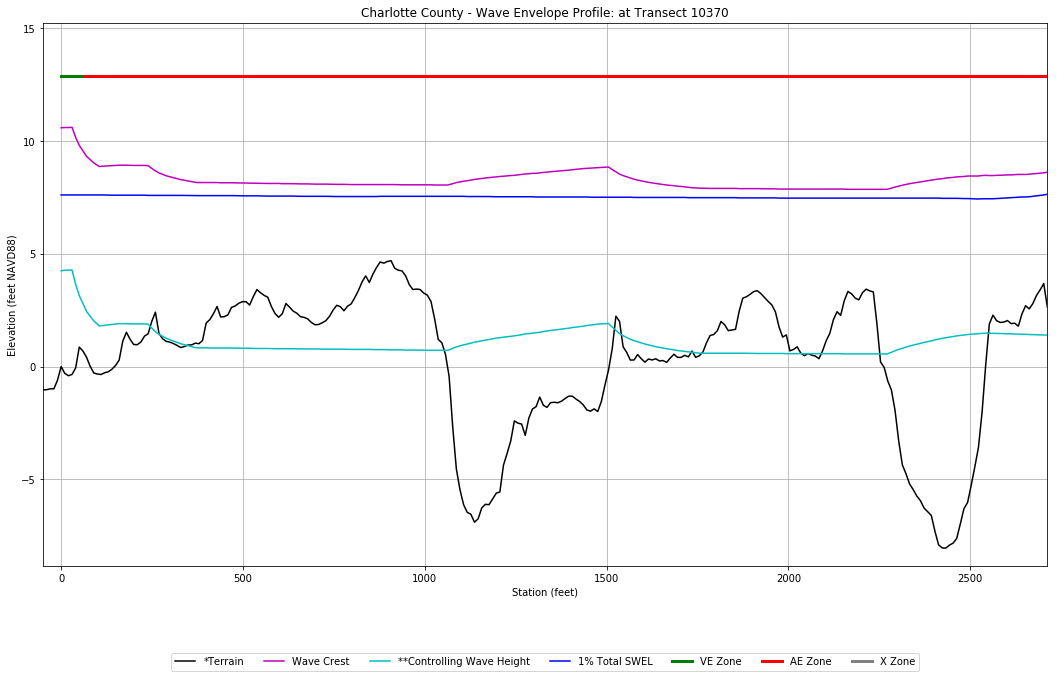

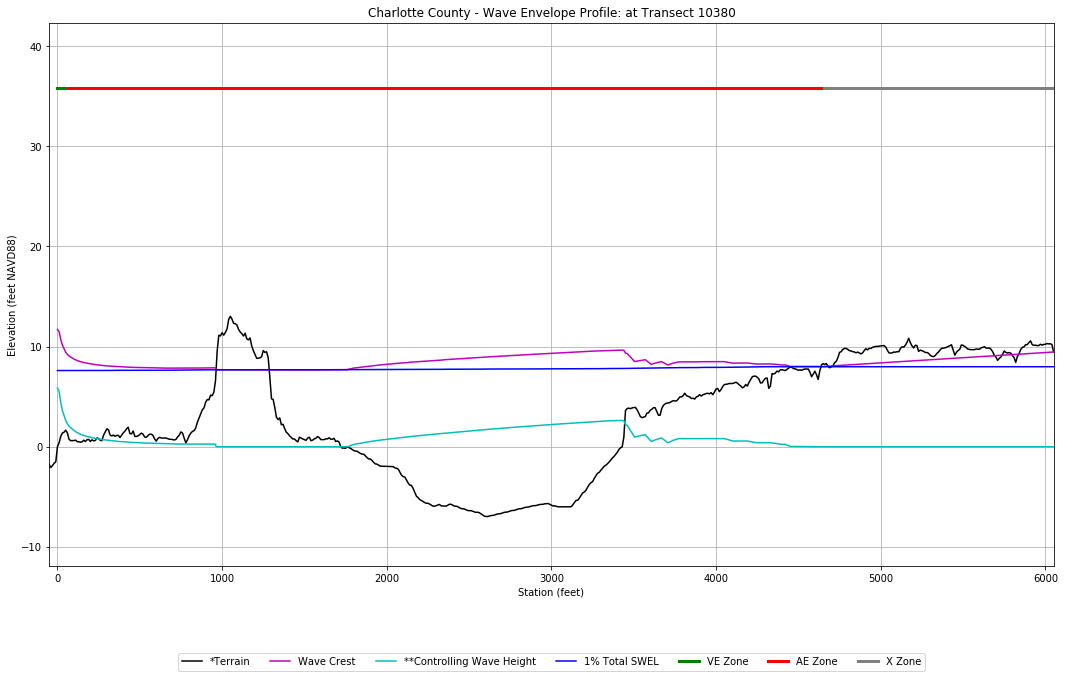

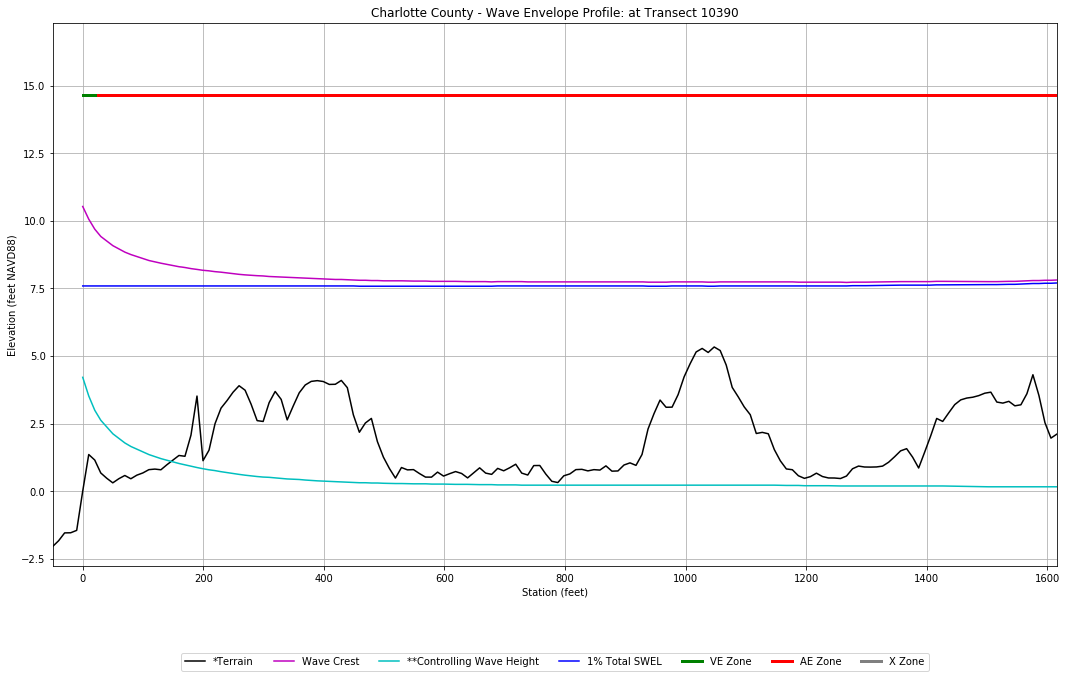

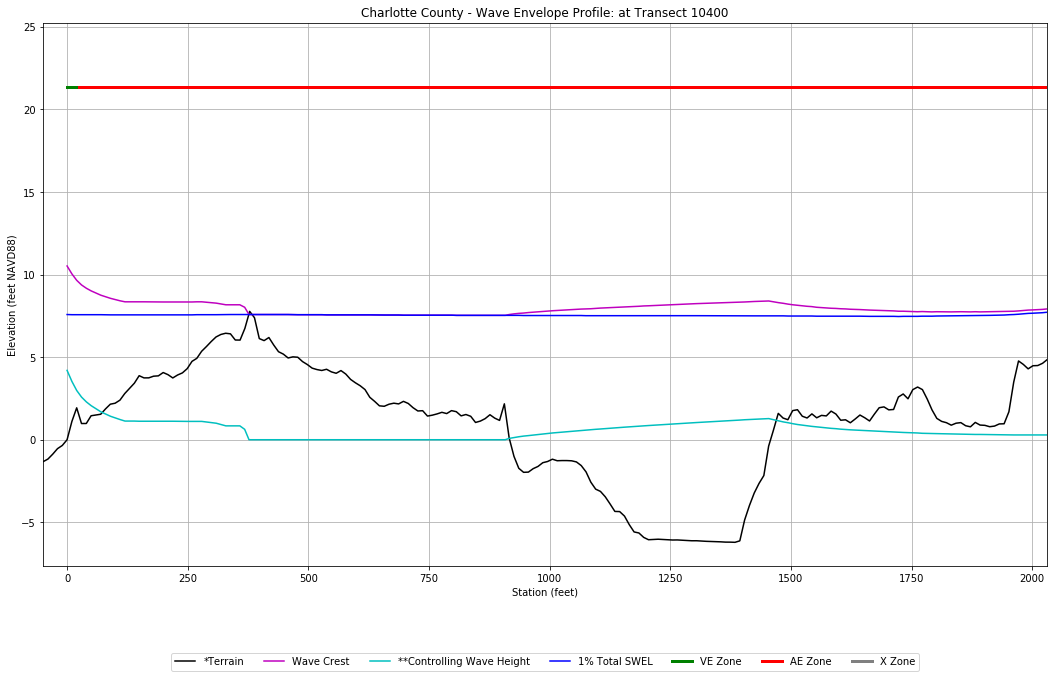

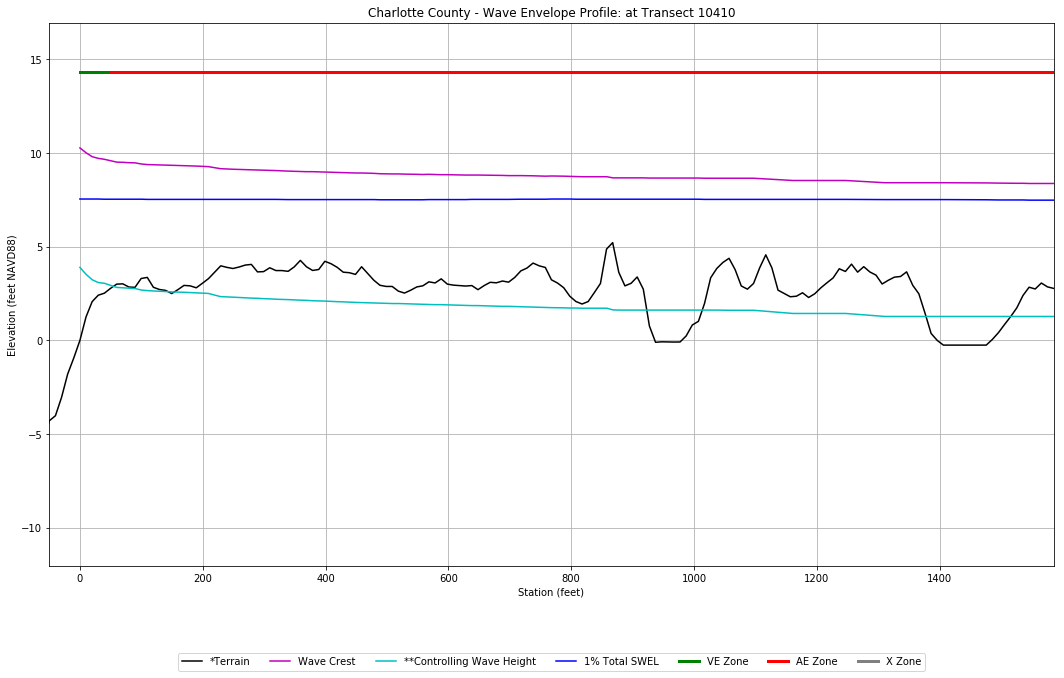

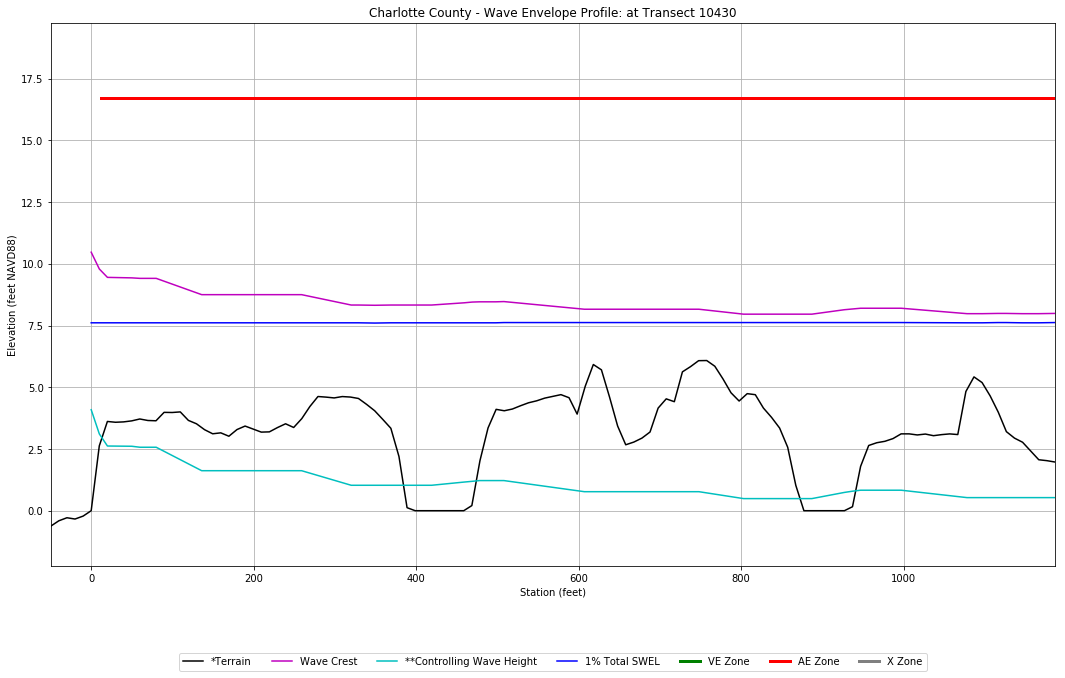

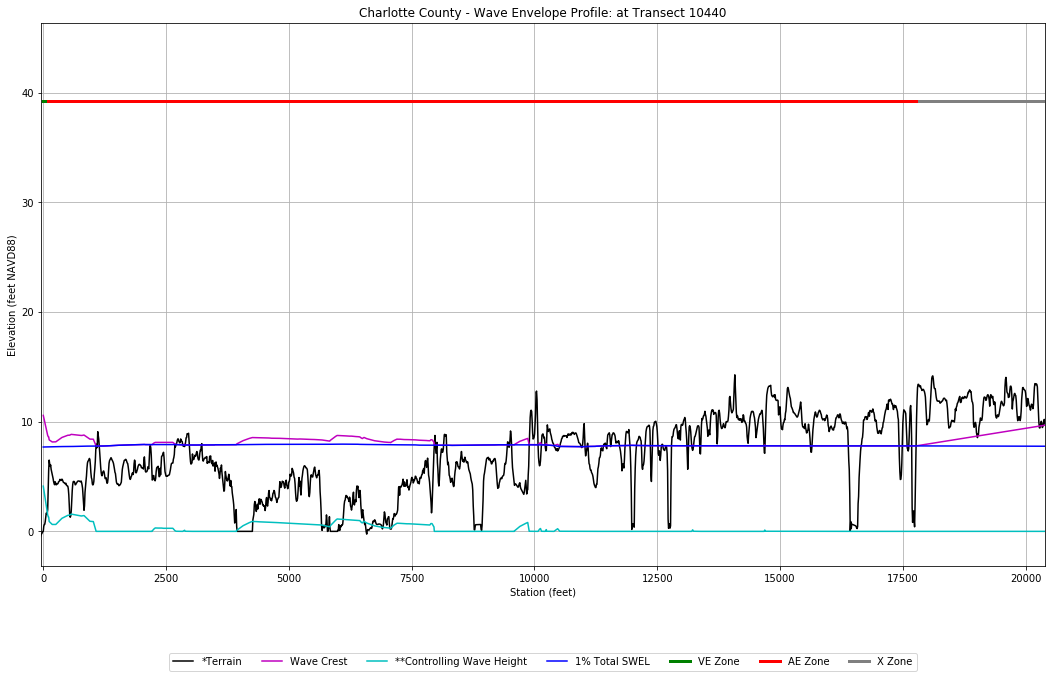

In [60]:

for t in transects[1:20]:
    erosion_profile = dfE[dfE['Transect'] == t]
    sorted_erosion = erosion_profile.sort_values(by='Station')
    original_profile = dfT2[dfT2['Transect'] == t]
    sorted_original = original_profile.sort_values(by='Station')
    zone_profile = dfZ2[dfZ2['Transect'] == t]
    sorted_zone = zone_profile.sort_values(by='Station begin')
    change = pd.merge(sorted_original,sorted_erosion,how='outer',indicator='Exist')
    change = change.loc[change['Exist'] != 'both']
    if t in transects_wave:
        if len(change)>1:
            fig = plt.figure(figsize=(18,10))
            ax1 = plt.axes([0,0.7,1,0.3])
            ax2 = plt.axes([0,0,1,0.6])
            ax1.plot(sorted_erosion['Station'], sorted_erosion['Elevation'],'k')
            ax1.plot(sorted_original['Station'],sorted_original['Elevation'],'--k')
            ax2.plot(sorted_original['Station'],sorted_original['Elevation'],'k')
            wave_profile = dfW2[dfW2['Transect'] == t]
            sorted_wave = wave_profile.sort_values(by='Stations')
            ax2.plot(sorted_wave['Stations'], sorted_wave['Wave_crest_elevation'],'-m')
            ax2.plot(sorted_wave['Stations'], sorted_wave['Wave_height'],'-c')
            still_profile = dfS2[dfS2['Transect'] == t]
            sorted_still = still_profile.sort_values(by='Station')
            ax2.plot(sorted_still['Station'], sorted_still['100_year_swell'],'-b')

            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('V')]['Station begin'],
                    sorted_zone[sorted_zone['zone'].str.match('V')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'-g',linewidth=3.0)            
 
            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('A')]['Station begin'],
                     sorted_zone[sorted_zone['zone'].str.match('A')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'r',linewidth=3.0)

            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('X')]['Station begin'],
                     sorted_zone[sorted_zone['zone'].str.match('X')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'grey',linewidth=3.0)

            ax2.legend(['*Terrain','Wave Crest','**Controlling Wave Height','1% Total SWEL','VE Zone','AE Zone','X Zone'],
                      loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=7)
            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('V')]['station end'],
                    sorted_zone[sorted_zone['zone'].str.match('V')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'-g',linewidth=3.0)
            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('A')]['station end'],
                     sorted_zone[sorted_zone['zone'].str.match('A')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'r',linewidth=3.0)
            ax2.plot(sorted_zone[sorted_zone['zone'].str.match('X')]['station end'],
                     sorted_zone[sorted_zone['zone'].str.match('X')]['elevation end']*0+
                    2.75*sorted_erosion['Elevation'].max(),'grey',linewidth=3.0) 
            
            ax1.set_xlim(0, .55*sorted_erosion['Station'].max())
            ax1.set_ylim(sorted_erosion['Elevation'].min(), 2.5*sorted_erosion['Elevation'].max())
            ax1.set_xlabel('Station (feet)')
            ax1.set_ylabel('Elevation (feet NAVD88)')
            ax1.set_title(title+': at Transect {}'.format(t))
            ax2.set_xlim(-50, sorted_erosion['Station'].max())
            ax2.set_ylim(1.1*sorted_erosion['Elevation'].min(), 3.25*sorted_erosion['Elevation'].max())
            ax2.set_xlabel('Station (feet)')
            ax2.set_ylabel('Elevation (feet NAVD88)')

        else:
            fig, ax = plt.subplots(figsize=(18,10))
            z1=ax.plot(sorted_original['Station'],sorted_original['Elevation'],'k')
            wave_profile = dfW2[dfW2['Transect'] == t]
            sorted_wave = wave_profile.sort_values(by='Stations')
            z2=ax.plot(sorted_wave['Stations'], sorted_wave['Wave_crest_elevation'],'-m')
            z3=ax.plot(sorted_wave['Stations'], sorted_wave['Wave_height'],'-c')
            still_profile = dfS2[dfS2['Transect'] == t]
            sorted_still = still_profile.sort_values(by='Station')
            z4=ax.plot(sorted_still['Station'], sorted_still['100_year_swell'],'-b')

            z5=ax.plot(sorted_zone[sorted_zone['zone'].str.match('V')]['Station begin'],
                    sorted_zone[sorted_zone['zone'].str.match('V')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'-g',linewidth=3.0,zorder=5)            
  
            z6=ax.plot(sorted_zone[sorted_zone['zone'].str.match('A')]['Station begin'],
                     sorted_zone[sorted_zone['zone'].str.match('A')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'r',linewidth=3.0,zorder=4)

            z7=ax.plot(sorted_zone[sorted_zone['zone'].str.match('X')]['Station begin'],
                     sorted_zone[sorted_zone['zone'].str.match('X')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'grey',linewidth=3.0,zorder=3)        

            ax.legend(['*Terrain','Wave Crest','**Controlling Wave Height','1% Total SWEL','VE Zone','AE Zone','X Zone'],
                      loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=7)
            ax.plot(sorted_zone[sorted_zone['zone'].str.match('V')]['station end'],
                    sorted_zone[sorted_zone['zone'].str.match('V')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'-g',linewidth=3.0,zorder=5)
            ax.plot(sorted_zone[sorted_zone['zone'].str.match('A')]['station end'],
                     sorted_zone[sorted_zone['zone'].str.match('A')]['elevation begin']*0+
                    2.75*sorted_erosion['Elevation'].max(),'r',linewidth=3.0,zorder=4)
            ax.plot(sorted_zone[sorted_zone['zone'].str.match('X')]['station end'],
                     sorted_zone[sorted_zone['zone'].str.match('X')]['elevation end']*0+
                    2.75*sorted_erosion['Elevation'].max(),'grey',linewidth=3.0,zorder=3) 
                        
            ax.set_xlim(-50, sorted_erosion['Station'].max())
            ax.set_ylim(1.1*sorted_erosion['Elevation'].min(), 3.25*sorted_erosion['Elevation'].max())
            ax.set_xlabel('Station (feet)')
            ax.set_ylabel('Elevation (feet NAVD88)')
            ax.set_title(title+': at Transect {}'.format(t))
    #else:
     #   ax3 = plt.axes([0,0,1,1])
     #   ax3.plot(sorted_erosion['Station'], sorted_erosion['Elevation'],'k')
     #   ax3.plot(original_profile['Station'],original_profile['Elevation'],'--k')        
     #   ax3.set_xlim(-50, sorted_erosion['Station'].max())
     #   ax3.set_ylim(1.1*sorted_erosion['Elevation'].min(), 1.5*sorted_erosion['Elevation'].max())
     #   ax3.set_xlabel('Station (feet)')
     #   ax3.set_ylabel('Elevation (feet NAVD88)')
     #   ax3.set_title(title+': at Transect {}'.format(t))
     #   ax3.legend(['Erosion','Terrain'],loc='upper center',bbox_to_anchor=(0.5,-0.1),ncol=2)
    #ax.axvline(0, color = 'black')

    
    plt.grid(True)
    #plt.savefig(path+'{}.png'.format(t),dpi=300, bbox_inches = 'tight', pad_inches = 0.1)
    #plt.close() 